# Golf

Ported from Eric Novik's [`Stan` example](https://github.com/ericnovik/golf).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from scipy import stats as st

from utils import plt, sns

In [2]:
df = pd.read_csv("data/golf.csv")
df["per"] = (df.success / df.tries).round(3)
print len(df)
df.head(10)

19


,distance,success,tries,per
0,1,1346,1443,0.933
1,2,577,694,0.831
2,3,337,455,0.741
3,4,208,353,0.589
4,5,149,272,0.548
5,6,136,256,0.531
6,7,111,240,0.462
7,8,69,217,0.318
8,9,67,200,0.335
9,10,75,237,0.316


(0, 20)

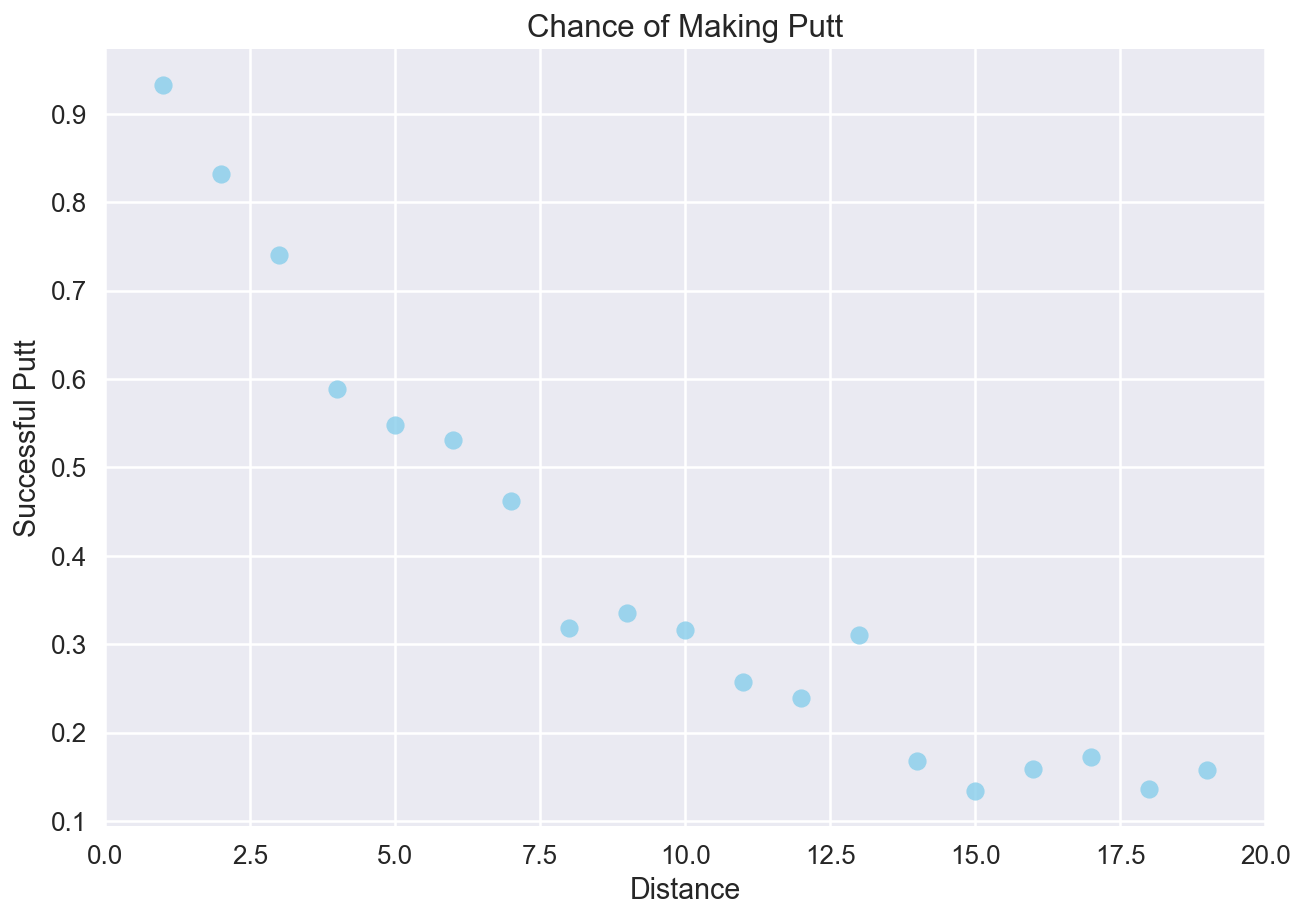

In [3]:
sns.regplot(df.distance, df.success/df.tries, fit_reg=False)
plt.title("Chance of Making Putt")
plt.ylabel("Successful Putt")
plt.xlabel("Distance")
plt.xlim(0, 20)

In [4]:
def probit_phi(x):
    """ Probit transform assuming 0 mean and 1 sd """
    # http://stackoverflow.com/questions/21849494/
    mu, sd = 0, 1
    return 0.5 * (1 + tt.erf((x - mu) / (sd * tt.sqrt(2))))

tin_cup_radius = (4.25 - 1.68) / 2.0
putt_chance = np.sin(tin_cup_radius / df.distance.values)

In [5]:
with pm.Model() as model:
    # Priors
    sigma = pm.HalfCauchy("sigma", 2.5)
    theta = probit_phi(1.0 / sigma * putt_chance)
    probability = 2.0 * theta - 1.0

    # Likelihood
    y = pm.Binomial("y", df.tries.values, probability, shape=19, observed=df.success.values)
    
    # Sample
    trace = pm.sample(draws=10000, tune=5000, njobs=4, chain=4)
    
burn_in = 5000
trace = trace[burn_in:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -148.68: 100%|██████████| 200000/200000 [00:10<00:00, 18561.85it/s]
Finished [100%]: Average ELBO = -148.67
100%|██████████| 10000/10000 [00:05<00:00, 1694.82it/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5
sigma  0.430028  0.006545   0.00007  0.416793  0.442939


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ed041d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114fefc90>]], dtype=object)

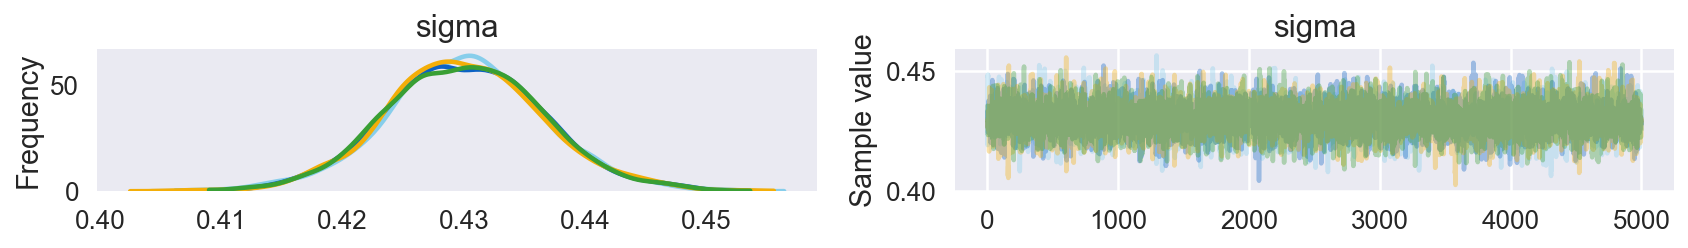

In [6]:
print(pm.df_summary(trace))
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11467e910>], dtype=object)

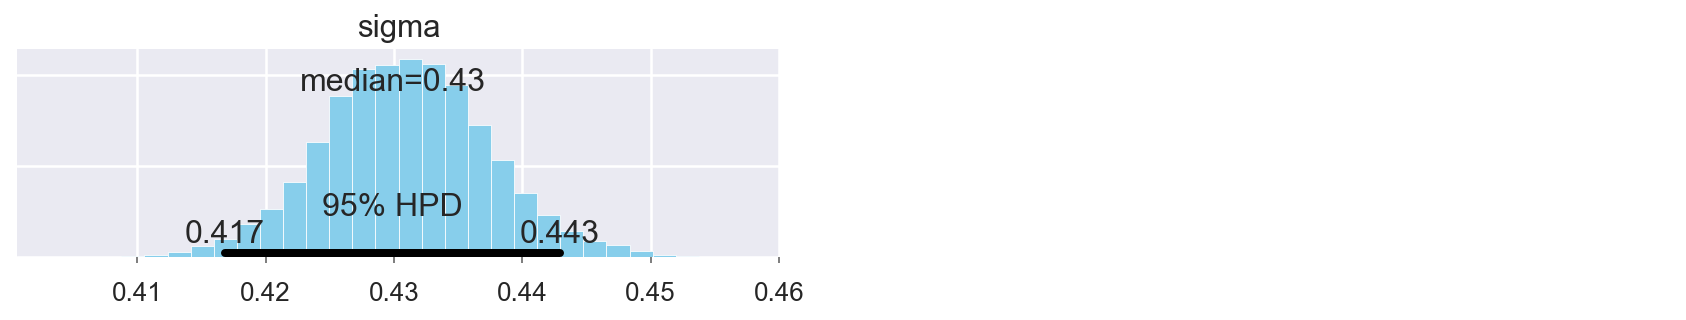

In [7]:
pm.plot_posterior(trace, point_estimate="median")

In [8]:
pm.diagnostics.gelman_rubin(trace)

{'sigma': 0.99996945389298708, 'sigma_log_': 0.99997014871079104}

In [9]:
ppc = pm.sample_ppc(trace, model=model)

100%|██████████| 5000/5000 [00:16<00:00, 304.05it/s]


count    5000.000000
mean     1405.813200
std         6.823402
min      1377.000000
25%      1401.000000
50%      1406.000000
75%      1411.000000
max      1427.000000
dtype: float64


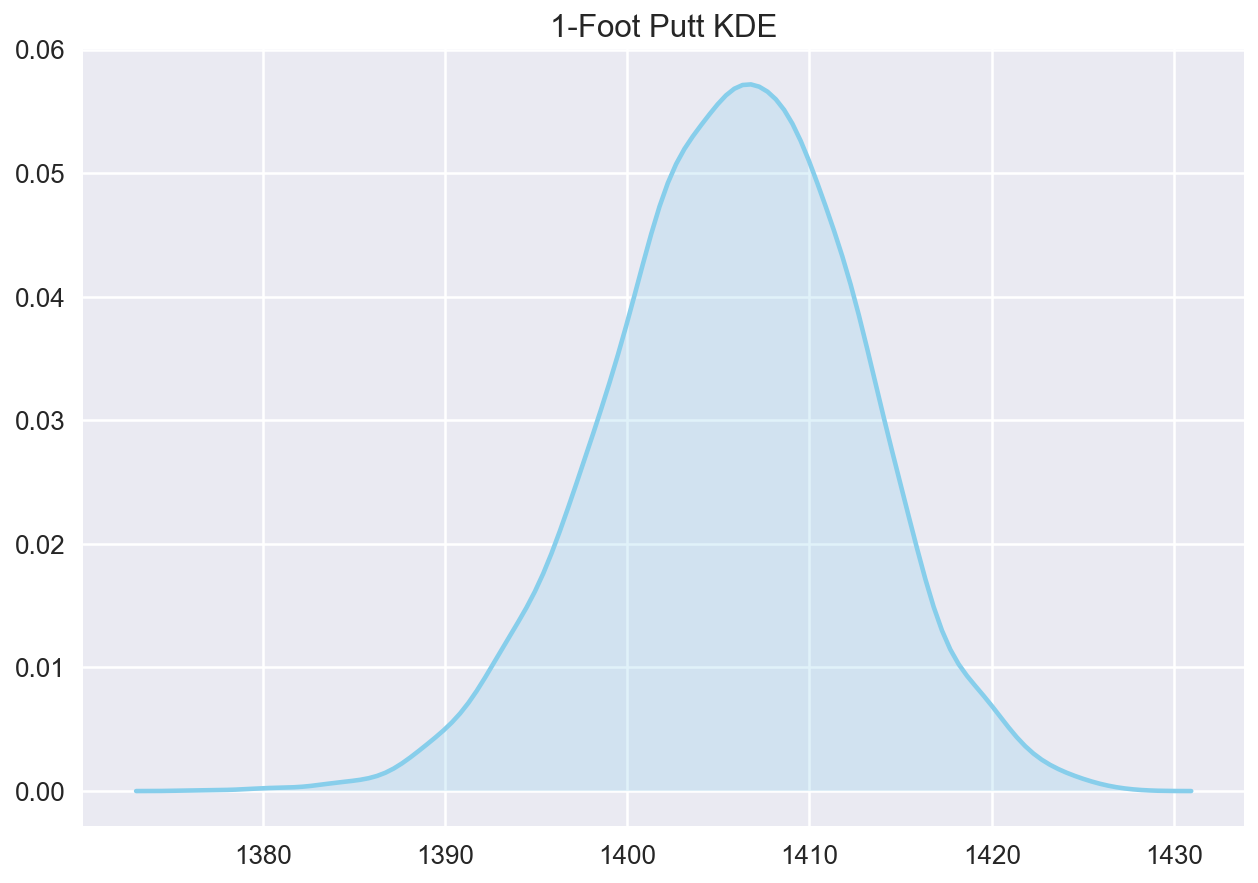

In [10]:
putt = pd.Series(ppc["y"][:, 0])
print putt.describe()
sns.kdeplot(ppc["y"][:, 0], shade=True)
plt.title("1-Foot Putt KDE")

count    5000.000000
mean     1405.813200
std         6.823402
min      1377.000000
25%      1401.000000
50%      1406.000000
75%      1411.000000
max      1427.000000
dtype: float64


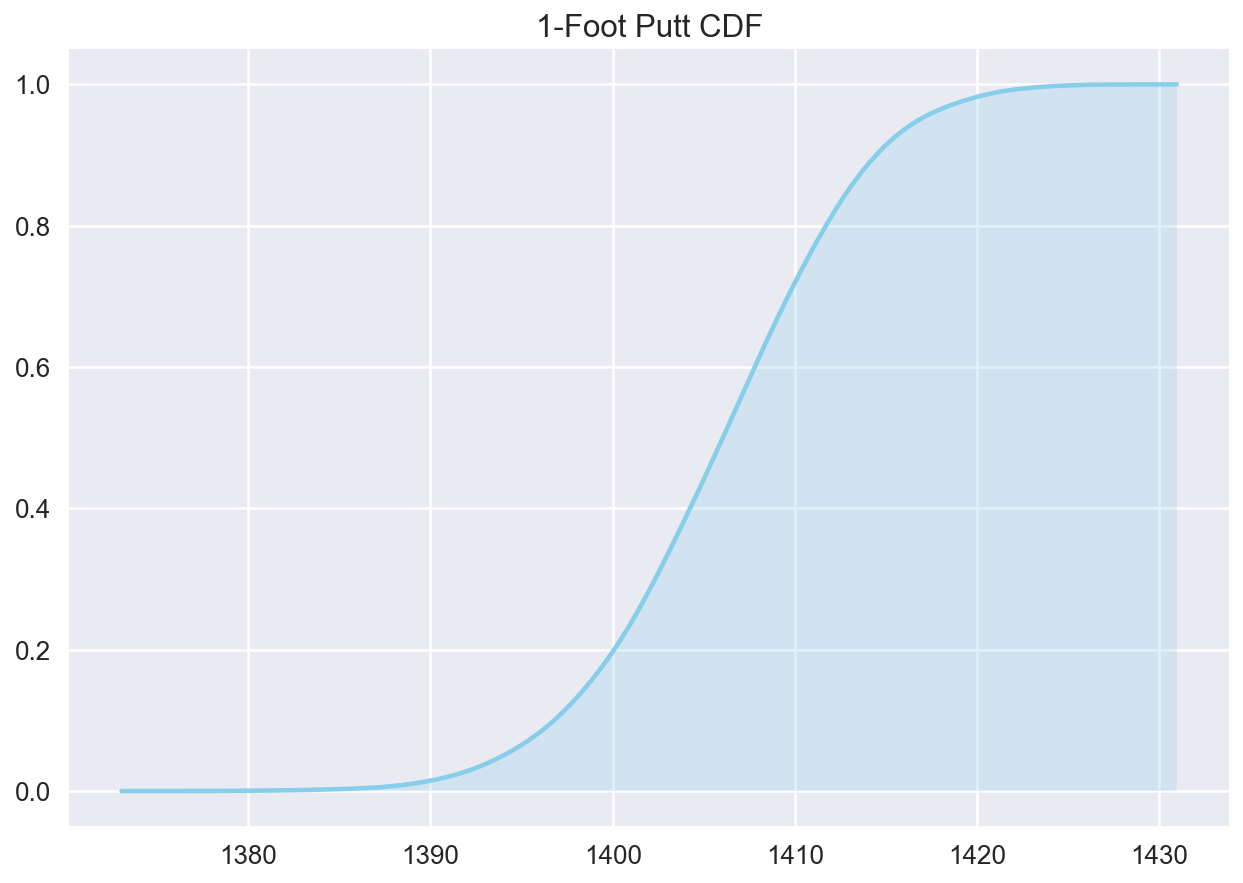

In [11]:
putt = pd.Series(ppc["y"][:, 0])
print putt.describe()
sns.kdeplot(ppc["y"][:, 0], cumulative=True, shade=True)
plt.title("1-Foot Putt CDF")